# Spike-driven Transformer

This notebook provides a simple implementation of Spike-driven Transformer. It is based on the following sources:

* **Paper**: Yao, Man, et al. "[Spike-driven Transformer.](https://arxiv.org/abs/2307.01694)" arXiv preprint arXiv:2307.01694 (2023).
* **Source Code**: [BICLab/Spike-Driven-Transformer (Github)](https://github.com/BICLab/Spike-Driven-Transformer) repository

If you're not familiar with Spiking Neural Networks (SNNs) and snnTorch, please refer to the [snnTorch Tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) before beginning this notebook. Also, please refer to the previous work [Spikformer](spikformer.ipynb) notebook.

## Introduction

This paper proposes the Spike-driven Transformer which only exploits sparse addition. This spike-driven paradigm is hardware-friendly to neuromorphic chips. Core contributions of this paper are:

* **Spike-Driven Self-Attention (SDSA)**: replaces the self-attention operator between spike Query, Key, and Value with mask and sparse addition, resulting in linear time complexity.
* **Membrane Shortcut (MS)**: rearranges the residual connections so that all spiking neurons communicate via binary spikes.

The Spike-driven Transformer overcomes the limitations of the Spikformer, outperforming or comparable to the Spikformer on both static and neuromorphic datasets. For instance, it achieves 77.1% top-1 accuracy on ImageNet-1K.

At the foremost, import required packages:

In [ ]:
!pip install snntorch

In [2]:
import matplotlib.pyplot as plt
import snntorch as snn
import torch
import torch.nn as nn
import torch.optim as optim
from snntorch import surrogate, utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## DataLoading

For the sake of simplicity, we will train the Spike-driven Transformer on the MNIST dataset.

In [3]:
batch_size = 128
data_path='data/mnist'

Create dataloaders:

In [4]:
C = 1
H = 28
W = 28

# Define a transform
transform = transforms.Compose([
            transforms.Resize((H, W)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

## Spike-driven Transformer Implementation

Let's define two common variables to train our SNN:

In [5]:
BETA = 0.9 # membrane potential decay rate
SPIKE_GRAD = surrogate.fast_sigmoid() # surrogate gradient function

### Spike-Driven Self-Attention (SDSA)

The Spiking Self-Attention (SSA) of the Spikformer converts Query, Key, and Value into spike-form to calculate the attention map by spike matrix multiplications instead of the softmax function. But this not only yields large integers in the output (thus requiring an additional scale multiplication for normalization) but also fails to exploit the full energy-efficiency potential of the spike-driven paradigm. To address these issues, the authors propose the **Spike-Driven Self-Attention (SDSA)**:

1. **Hadamard Product**: replaces the matrix multiplication in the self-attention with Hadamard product (element-wise multiplication) between spikes, which is equivalent to the element-wise mask.
2. **Matrix Column-wise Summation Followed by Spiking Neuron Layer**: take the role of softmax and scale, resulting in a sparse matrix (typically, the ratio of non-zero elements is less than 0.02).

The figure below illustrates the calculation of SDSA (Version 1):

![](img/spike-driven-transformer/vsa-sdsa.png)

Let's delve into the details of the SDSA. Given a spike input feature sequence $S \in \mathbb{R}^{T \times N \times D}$, the spike-form $Q$, $K$, and $V$ are computed using different spiking neuron layers like in the Spikformer:

$$
Q = \mathcal{SN}_Q (\text{BN}(SW_Q)), \quad K = \mathcal{SN}_K (\text{BN}(SW_K)), \quad V = \mathcal{SN}_V (\text{BN}(SW_V))
$$

where $W_Q$, $W_K$ and $W_V$ are the learning weight matrices for the Query, Key, and Value respectively. $\mathcal{SN}$ is the spiking neuron layer, and $\text{BN}$ is the batch normalization layer. The key difference between SDSA and SSA is here! SDSA Version 1 is calculated as follows:

$$
SDSA(Q, K, V) = \mathcal{SN} (\text{SUM}_c (Q \otimes K)) \otimes V,
$$

where $\otimes$ is the Hadamard product (element-wise multiplication), and $\text{SUM}_c$ is the sum of each column (sum over the sequence dimension $N$). Since the Hadamard product among $Q$, $K$, and $V$ can be exchanged, the SDSA can be rewritten as:

$$
SDSA(Q, K, V) = Q \otimes \mathcal{SN} (\text{SUM}_c (K \otimes V)).
$$

In this view, the above equation is a linear attention whose computational complexity is linear in the token number $N$ since $K$ and $V$ can participate in calculation first. Therefore, we will implement the SDSA in this way.

The above description of SDSA is a single-head version. This can be easily extended to multi-head SDSA, similar to the one used in the original Transformer. The visual representation of the SDSA module highlighted in the red box can be seen in the figure below:

![](img/spike-driven-transformer/sdsa.png)

Wait! If you learn the Spikformer before, you may find the orders of the spike neuron layers in the SDSA are different from the Spikformer. This is because the authors proposed to rearrange the residual connections, enabling all spiking neurons to communicate via binary spikes. We will discuss this in the next section. 

Anyway, let's implement the SDSA module in snnTorch. We will use Leaky Integrate-and-Fire (LIF) neurons for the spiking neuron layers, which is defined as the `snnTorch.Leaky` class. For simplicity, we don't consider time steps $T$ during the initial implementation. At the end of the `SpikeDrivenTransformer` network, we will loop over the time steps $T$ to compute the final output.

In [6]:
class SDSA(nn.Module):
    """Spike-driven Self-Attention (SDSA)"""
    def __init__(self, dim, num_heads=8) -> None:
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
        
        self.dim = dim
        self.num_heads = num_heads
        
        self.shortcut_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.q_linear = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim) 
        self.q_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True) 
        
        self.k_linear = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.v_linear = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.attn_lif = snn.Leaky(beta=BETA, threshold=0.5, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.proj_linear = nn.Linear(dim, dim)
        self.proj_bn = nn.BatchNorm1d(dim)
        
    def forward(self, x):
        B, N, D = x.shape
        
        x = self.shortcut_lif(x) # apply spiking neuron first

        # Calculate spike-form Q, K, V
        q = self.q_linear(x) # linear transformation
        q = self.q_bn(q.transpose(-1, -2)).transpose(-1, -2) # batch normalization
        q = self.q_lif(q) # spiking neuron
        q = q.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2) # (B, num_heads, N, D // num_heads)
        
        v = self.v_linear(x)
        v = self.v_bn(v.transpose(-1, -2)).transpose(-1, -2)
        v = self.v_lif(v)
        v = v.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        
        k = self.k_linear(x)
        k = self.k_bn(k.transpose(-1, -2)).transpose(-1, -2)
        k = self.k_lif(k)
        k = k.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)

        # Calculate spike-driven multi-head self-attention via element-wise multiplication and summation over sequence dimension
        kv = k * v
        kv = kv.sum(dim=-2, keepdim=True) # (B, num_heads, 1, D // num_heads)
        kv = self.attn_lif(kv)
        sdsa = q * kv # (B, num_heads, N, D // num_heads)
        sdsa = sdsa.transpose(1, 2).reshape(B, N, D) # (B, N, D)
        
        # Project the output
        sdsa = self.proj_linear(sdsa)
        sdsa = self.proj_bn(sdsa.transpose(-1, -2)).transpose(-1, -2)
        
        return sdsa

### Spike-driven Encoder Block

The next step is to implement the Spike-driven Encoder Block. The encoder block consists of SDSA and MLP modules, similar to the Spikformer. The key difference lies in the residual connection. Spikformer uses the Spike-Element-Wise (SEW) shortcut as residual connections. Since the SEW shortcut adds binary spikes, the values in the spike tensors become multi-bit (integer) spikes, making it difficult to fully utilize the spike-driven function, which supports only binary spikes.

The authors argue that the Membrane Shortcut (MS) is more desirable than the SEW shortcut. MS creates a shortcut between the membrane potentials of spiking neurons, while the SEW shortcut connects the output spikes. The reasons why MS is better than SEW are as follows:

1. **Spike-driven**: $\mathcal{SN}$ is followed by the MS shortcut, ensuring that only binary spike signals exist in the spike tensor.
2. **High performance**: The task accuracy of MS-Res-SNN is higher than that of SEW-Res-SNN.
3. **Bio-plausibility**: The MS shortcut can be understood as an approach to optimize the membrane potential distribution, aligning with other neuroscience-inspired methods.
4. **Dynamical isometry**: MS-Res-SNN has been proven to satisfy the dynamical isometry theory.

Specifically, given an input feature sequence or membrane potential $U_0 \in \mathbb{R}^{T \times N \times D}$, the output of the $L$-block Spike-driven encoder is computed as follows:

$$
\begin{aligned}
S_{l-1} &= \mathcal{SN}(U_{l-1}), \quad &S_{l-1} \in \mathbb{R}^{T \times N \times D}, l = 1 \dots L \\
U_l' &= \text{SDSA}(S_{l-1}) + U_{l-1}, \quad &U_l' \in \mathbb{R}^{T \times N \times D}, l = 1 \dots L \\
S_l' &= \mathcal{SN}(U_l'), \quad &S_l' \in \mathbb{R}^{T \times N \times D}, l = 1 \dots L \\
U_l &= \text{MLP}(S_l') + U_l', \quad &U_l \in \mathbb{R}^{T \times N \times D}, l = 1 \dots L \\
\end{aligned}
$$

The implementation of the MS shortcut is straightforward. Just apply spiking neuron layer before linear transformation! For example, the SEW shortcut like in the Spikformer is as such:

```python
x = linear(x) # or conv(x)
x = bn(x)
x = lif(x)
```

In contrast, the MS shortcut is:

```python
x = lif(x)
x = linear(x) # or conv(x)
x = bn(x)
```

That's it! In the practical implementation, Each $\mathcal{SN}$ before $\text{SDSA}$ and $\text{MLP}$ is implemented in the `forward` methods of `SDSA` and `MLP` classes respectively. The visual representation of the Spike-driven encoder block with MS shortcut is shown below:

![](img/spike-driven-transformer/encoder-block.png)

Now, let's implement the MLP:

In [7]:
class MLP(nn.Module):
    """Multi-layer Perceptron"""
    def __init__(self, in_features, hidden_features=None, out_features=None) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.fc1_linear = nn.Linear(in_features, hidden_features)
        self.fc1_bn = nn.BatchNorm1d(hidden_features)
        
        self.fc2_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.fc2_linear = nn.Linear(hidden_features, out_features)
        self.fc2_bn = nn.BatchNorm1d(out_features)
        
        self.hidden_dim = hidden_features
        self.out_dim = out_features
        
    def forward(self, x):
        # x: (B, N, D)
        x = self.fc1_lif(x) # apply spiking neuron first
        x = self.fc1_linear(x)
        x = self.fc1_bn(x.transpose(-1, -2)).transpose(-1, -2)
        
        x = self.fc2_lif(x) # apply spiking neuron first
        x = self.fc2_linear(x)
        x = self.fc2_bn(x.transpose(-1, -2)).transpose(-1, -2)
        return x

and then, implement the Spike-driven encoder block:

In [8]:
class SpikeDrivenEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0) -> None:
        super().__init__()
        self.attn = SDSA(dim, num_heads=num_heads)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim)
        
    def forward(self, x):
        # residual connection is used
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

Actually, it is same as the `SpikformerEncoderBlock` except for the `SDSA`.

### Spiiking Patch Splitting

The **Spiking Patch Splitting (SPS)** module linearly projects an image into a $D$-dimensional spike-form feature vector and splits it into a sequence of $N$ flattened spike-form patches $s$. The authors follow the design of the SPS in the Spikformer. See details in the [Spiking Patch Splitting](spikformer.ipynb) section of the Spikformer notebook.

The only difference is that the spiking neuron layer is moved from the end of the final patch splitting module (PSM) block to the beginning of the relative positional embedding (RPE) block, and then the spiking neuron layer in the RPE block is removed. Represented as pseudo code, the changes are as follows.

**Before:**

```python
# Final PSM block
x = conv3(x)
x = bn3(x)
x = lif3(x)
x = maxpool3(x)

# RPE block
rpe = rpe_conv(x)
rpe = rpe_bn(rpe)
rpe = rpe_lif(rpe)
x = x + rpe
```

**After:**

```python
# Final PSM block
x = conv3(x)
x = bn3(x)
x = maxpool3(x)

# RPE block
rpe = rpe_lif(x)
rpe = rpe_conv(rpe)
rpe = rpe_bn(rpe)
x = x + rpe
```

The visual representation of the SPS module is shown below:

![](img/spike-driven-transformer/sps.png)

Now, let's implement the SPS module. We will use a four-block SPS (the first two blocks do not contain the max-pooling layer) to split a $28 \times 28$ MNIST image into $49$ $4 \times 4$ patches. This design choice is inspired by the CIFAR-10 experiment in the Spikformer paper. Additionally, we will implement the SPS with RPE as the `SPS` class and perform the $X_0 = x + \text{RPE}$ operation at the image level (i.e., without flattening into $N$ patches) for simplicity.

In [9]:
class SPS(nn.Module):
    """4 x 4 Spiking Patch Splitting (SPS)"""
    def __init__(self, in_channels, embed_dim=256) -> None:
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, embed_dim // 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(embed_dim // 8)
        self.lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.conv1 = nn.Conv2d(embed_dim // 8, embed_dim // 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(embed_dim // 4)
        self.lif1 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        # Two times downsampling
        self.conv2 = nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(embed_dim // 2)
        self.lif2 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # Two times downsampling
        self.conv3 = nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(embed_dim)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.rpe_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)    
        self.rpe_conv = nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.rpe_bn = nn.BatchNorm2d(embed_dim)
        
    def forward(self, x):
        # x: (B, C, H, W)
        # Convolutional layers for inductive bias
        x = self.conv(x)
        x = self.bn(x)
        x = self.lif(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.lif1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lif2(x)
        x = self.maxpool2(x)
        
        # There is no spiking neuron in the final PSM block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.maxpool3(x)
        
        # Relative position embedding
        rpe = self.rpe_lif(x) # for membrane shortcut
        rpe = self.rpe_conv(rpe)
        rpe = self.rpe_bn(rpe)
        x = x + rpe
        
        # Split into an image patches sequence
        x = x.flatten(-2).transpose(-2, -1) # (B, N, D)
        return x

### Spike-driven Transformer

Finally, we can implement the Spike-driven Transformer. The Spike-driven Transformer model consists of the following components:

1. **Spiking Patch Splitting (SPS)**: converts the input image into a sequence of spike-form patches.
2. **Spike-driven Encoder Blocks**: a series of $L$ stacked Spike-driven encoder blocks, each containing SSA and MLP components.
3. **Classification Head**: a linear layer that maps the output of the last encoder block to the final classification output.

First of all, the `SpikeDrivenTransformer` model takes as input an image batch `image_batch` of shape `(B, C, H, W)`. To integrate membrane potentials and generate spikes in spiking neuron layers, our `SpikeDrivenTransformer` model iterates the forward pass of SPS followed by $L$-block Spike-driven encoder over $T$ time steps. For each time step, a global average-pooling (GAP) is utilized on the output of the last encoder block to obtain the $D$-dimensional feature vector. Then, the `head_lif` spiking neuron layer is applied to the feature vector. Finally, the stacked feature vectors over $T$ time steps are averaged to pass through the classification head. These can be represented mathematically: $Y = \text{CH}(\text{GAP}(\mathcal{SN}(U_L)))$.

In [10]:
class SpikeDrivenTransformer(nn.Module):
    def __init__(self, c, num_classes, embed_dim=256, num_heads=8, mlp_ratio=4.0, num_blocks=4, num_steps=4) -> None:
        super().__init__()
        self.num_steps = num_steps # T
        
        self.sps = SPS(c, embed_dim=embed_dim)
        self.spikformer_encoder_blocks = nn.ModuleList([
            SpikeDrivenEncoderBlock(embed_dim, num_heads, mlp_ratio) for _ in range(num_blocks)
        ])
        
        self.head_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.classification_head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, image_batch):
        # x: (B, C, H, W)
        x_rec = [] # record x over time steps
        
        # reset/initialize hidden states for all LIF neurons in net
        utils.reset(self.sps) 
        utils.reset(self.spikformer_encoder_blocks)
        utils.reset(self.head_lif)
        
        for step in range(self.num_steps):
            # one time step of the forward-pass
            x = self.sps(image_batch) # (B, N, D)
            for block in self.spikformer_encoder_blocks:
                x = block(x)
            x = x.mean(dim=1) # global average pooling -> (B, D)
            x = self.head_lif(x)
            x_rec.append(x)
        
        y = self.classification_head(torch.stack(x_rec).mean(0))
        return y

Congratulations! You have successfully implemented the Spike-driven Transformer model. Now, let's put everything together and train the model on the MNIST dataset.

## Training the Spike-driven Transformer Model

Set the device to GPU if available:

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


The authors demonstrated that Spikformer can be trained with a small number of time steps. In this implementation, we will use only 4 time steps for training, which is presented in the paper. Also, 1 epoch of training is sufficient to achieve a good performance on the MNIST dataset.

In [12]:
num_epochs = 1
num_steps = 4 # T

The model is trained using the AdamW optimizer. The loss function is the cross-entropy loss, since the output of the model is logits over the classes like in a standard classification task. Okay, Initialize the `SpikeDrivenTransformer` model, loss function, and optimizer:

In [13]:
net = SpikeDrivenTransformer(C, num_classes=10, embed_dim=256, num_blocks=4, num_steps=num_steps).to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

Define `accuracy_rate` function to compute the accuracy of the model:

In [14]:
def accuracy_rate(outputs, targets):
    predictions = torch.argmax(outputs, dim=-1)
    acc = (predictions == targets).to(torch.float32).mean().item()
    return acc

Now, let's train the model:

In [15]:
loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    net.train()
    
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        
        # feed forward
        outputs = net(data)
        
        # loss calculation
        loss = loss_fn(outputs, targets) 
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
        
        if i % 25 == 0:
            acc = accuracy_rate(outputs, targets)
            acc_hist.append(acc)
            print(f"[Epoch {epoch}, Iteration {i}] Train loss: {loss.item()}, Accuracy: {acc * 100:.2f}%\n")
    

[Epoch 0, Iteration 0] Train loss: 2.466102123260498, Accuracy: 7.03%

[Epoch 0, Iteration 25] Train loss: 0.7980519533157349, Accuracy: 78.91%

[Epoch 0, Iteration 50] Train loss: 0.5167995095252991, Accuracy: 84.38%

[Epoch 0, Iteration 75] Train loss: 0.31484732031822205, Accuracy: 91.41%

[Epoch 0, Iteration 100] Train loss: 0.19872580468654633, Accuracy: 95.31%

[Epoch 0, Iteration 125] Train loss: 0.272047221660614, Accuracy: 92.19%

[Epoch 0, Iteration 150] Train loss: 0.18213918805122375, Accuracy: 95.31%

[Epoch 0, Iteration 175] Train loss: 0.24992497265338898, Accuracy: 94.53%

[Epoch 0, Iteration 200] Train loss: 0.1556517332792282, Accuracy: 96.09%

[Epoch 0, Iteration 225] Train loss: 0.13570944964885712, Accuracy: 97.66%

[Epoch 0, Iteration 250] Train loss: 0.09765473008155823, Accuracy: 98.44%

[Epoch 0, Iteration 275] Train loss: 0.1659909337759018, Accuracy: 94.53%

[Epoch 0, Iteration 300] Train loss: 0.12003803998231888, Accuracy: 96.88%

[Epoch 0, Iteration 325] T

Plot the training loss and accuracy:

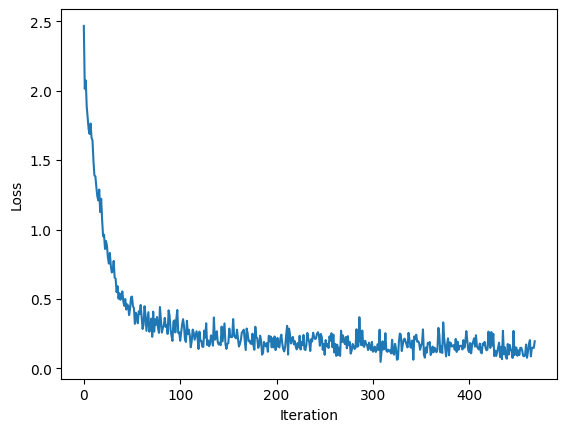

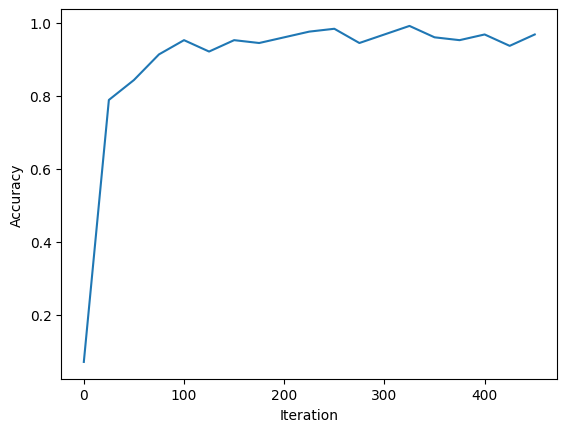

In [16]:
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.plot(torch.arange(len(acc_hist)) * 25, acc_hist)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

Let's evaluate the model on the test set:

In [17]:
@torch.no_grad()
def test_accuracy(dataloader, net):
    total = 0
    acc = 0
    
    for data, targets in iter(dataloader):
        data = data.to(device)
        targets = targets.to(device)
        
        outputs = net(data)
        
        acc += accuracy_rate(outputs, targets) * outputs.size(0)
        total += outputs.size(0)
        
    return acc / total

In [18]:
print(f"Test set accuracy: {test_accuracy(test_loader, net)*100:.3f}%")

Test set accuracy: 96.300%


Finished!